In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_error, classification_report
from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [10]:
import warnings
warnings.filterwarnings('ignore')

# Gather Data

In [11]:
df_x = pd.read_csv('data/datasets/streamflow_prediction_dataset_averaged_cols.csv', index_col=0, parse_dates=True)
df_y = pd.read_csv('data/datasets/streamflow_prediction_dataset.csv', index_col=0, parse_dates=True)['streamflow']

df_x['Snow'] = np.where((df_x['WTEQ_BisonLake'] > 0) | (df_x['WTEQ_McClurePass'] > 0), 1, 0)

df_x = df_x.drop(
    columns=[
        'WTEQ_BisonLake', 'WTEQ_McClurePass', 'soilmoisture_Avg_2ft', 
        'soilmoisture_Avg_4ft', 'soilmoisture_Avg_20ft'
    ]
)

df = pd.concat([df_x, df_y], axis=1)

df.to_csv('data/datasets/snow_soilmoisture_prediction_dataset.csv')

display(df)

,PREC_Avg,TAVG_Avg,soilmoisture_Avg_8ft,Snow,streamflow
date,,,,,
2008-03-12,26.00,24.80,17.74,1,2360.0
2008-03-15,26.55,17.55,17.88,1,2260.0
2008-03-17,26.70,19.35,18.04,1,2260.0
2008-03-18,26.70,17.85,18.06,1,2260.0
2008-03-19,26.70,25.50,18.06,1,2200.0
...,...,...,...,...,...
2021-07-23,24.20,57.50,14.60,0,1170.0
2021-07-24,24.40,55.85,14.38,0,1240.0
2021-07-25,24.65,55.15,14.24,0,1190.0


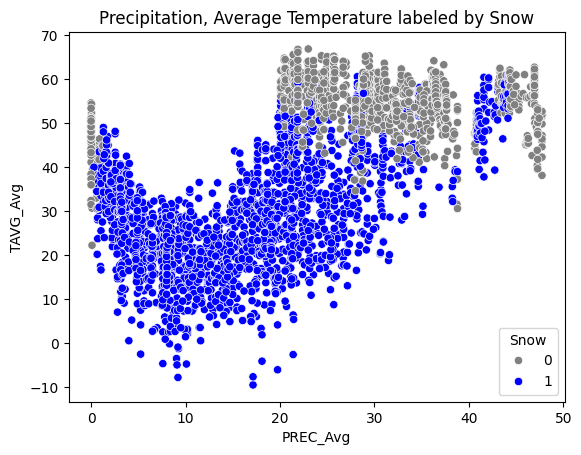

In [12]:
# visualize
palette={1: 'blue', 0: 'grey'}
sns.scatterplot(data=df, x='PREC_Avg', y='TAVG_Avg', hue='Snow', palette=palette)
plt.title('Precipitation, Average Temperature labeled by Snow')
plt.show()

# Random Forest - Snow

[[284  24]
 [ 35 556]]
Accuracy: 0.9343715239154616
Classification Report:               precision    recall  f1-score   support

           0       0.89      0.92      0.91       308
           1       0.96      0.94      0.95       591

    accuracy                           0.93       899
   macro avg       0.92      0.93      0.93       899
weighted avg       0.94      0.93      0.93       899



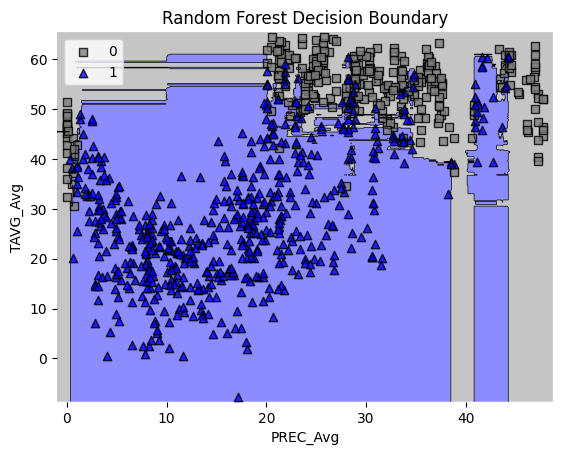

In [13]:
# Random Forest to predict snow
X = df[['PREC_Avg', 'TAVG_Avg']]
y = df['Snow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

snow_rf = RandomForestClassifier()
snow_rf.fit(X_train, y_train)
predictions = snow_rf.predict(X_test)

print(confusion_matrix(y_test, predictions))
print(f'Accuracy: {snow_rf.score(X_test, y_test)}')
print('Classification Report:', classification_report(y_test, predictions))

# visualize decision boundary
plot_decision_regions(X_test.values, y_test.values, clf=snow_rf, legend=2, colors='grey,blue')
plt.xlabel('PREC_Avg')
plt.ylabel('TAVG_Avg')
plt.title('Random Forest Decision Boundary')
plt.legend()
plt.show()

# LSTM - Soil Moisture

(2386, 10, 3)
Epoch 1/20
75/75 [==============================] - 1s 5ms/step - loss: 0.0422 - val_loss: 0.0327
Epoch 2/20
75/75 [==============================] - 0s 3ms/step - loss: 0.0281 - val_loss: 0.0322
Epoch 3/20
75/75 [==============================] - 0s 3ms/step - loss: 0.0258 - val_loss: 0.0271
Epoch 4/20
75/75 [==============================] - 0s 3ms/step - loss: 0.0249 - val_loss: 0.0275
Epoch 5/20
75/75 [==============================] - 0s 3ms/step - loss: 0.0241 - val_loss: 0.0202
Epoch 6/20
75/75 [==============================] - 0s 3ms/step - loss: 0.0234 - val_loss: 0.0251
Epoch 7/20
75/75 [==============================] - 0s 3ms/step - loss: 0.0225 - val_loss: 0.0267
Epoch 8/20
75/75 [==============================] - 0s 3ms/step - loss: 0.0224 - val_loss: 0.0264
Epoch 9/20
75/75 [==============================] - 0s 3ms/step - loss: 0.0223 - val_loss: 0.0301
Epoch 10/20
75/75 [==============================] - 0s 4ms/step - loss: 0.0222 - val_loss: 0.0272
Epoch

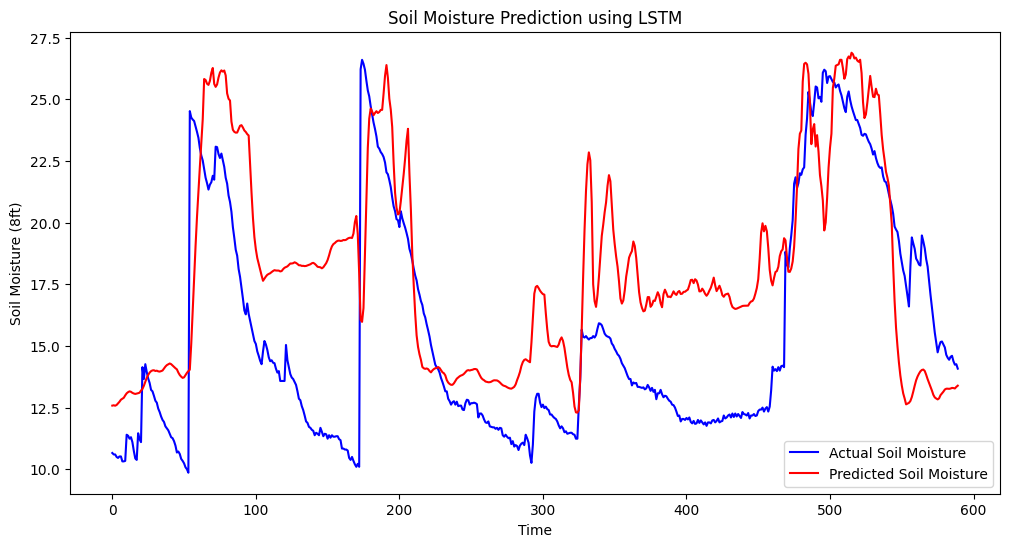

Mean Squared Error: 16.962768379382197
Mean Absolute Error: 3.5154418580006745
Accuracy: 96.48455814199933


In [14]:
soil_df = df.copy()

features = ['PREC_Avg', 'TAVG_Avg', 'Snow']
target = 'soilmoisture_Avg_8ft'

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(soil_df[features + [target]])

# Split data into train and test sets (80-20 split)
train_size = int(len(scaled_data) * 0.8)
train, test = scaled_data[:train_size], scaled_data[train_size:]

# Function to create LSTM sequences
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, :-1])  # Features
        y.append(data[i, -1])            # Target
    return np.array(X), np.array(y)

n_steps = 10  # Time steps to look back
X_train, y_train = create_sequences(train, n_steps)
X_test, y_test = create_sequences(test, n_steps)

# Define the LSTM soil_lstm
soil_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(n_steps, X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu', return_sequences=False),
    Dense(1)
])

# Compile the soil_lstm
soil_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the soil_lstm
print(X_train.shape)
history = soil_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, verbose=1)

# Predict on test data
y_pred = soil_lstm.predict(X_test)

# Inverse scale predictions and actuals
scaler_target = MinMaxScaler()
scaler_target.fit(soil_df[[target]])  # Fit only on target column
y_test_rescaled = scaler_target.inverse_transform(y_test.reshape(-1, 1))
y_pred_rescaled = scaler_target.inverse_transform(y_pred)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual Soil Moisture', color='blue')
plt.plot(y_pred_rescaled, label='Predicted Soil Moisture', color='red')
plt.title('Soil Moisture Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Soil Moisture (8ft)')
plt.legend()
plt.show()

# print accuracy metrics
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Accuracy: {100 - mae}')


# Predict

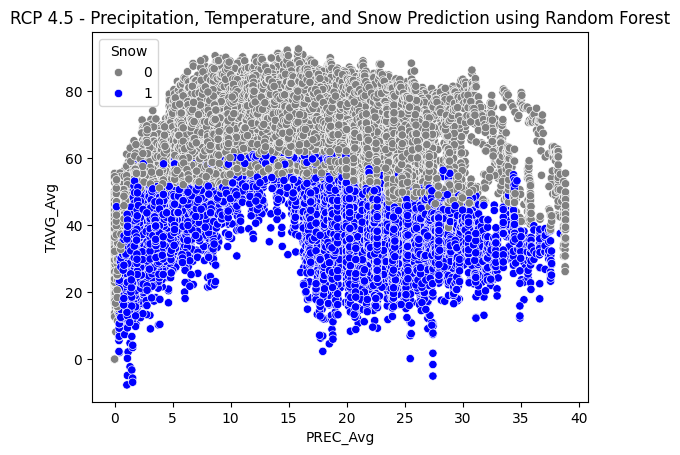

In [15]:
df_rcp45 = pd.read_csv('data/scenarios/rcp45_CanESM2-CanRCM4.csv', index_col=0, parse_dates=True)[['temp','prec_year']]
df_rcp45 = df_rcp45.rename(columns={'prec_year': 'PREC_Avg', 'temp': 'TAVG_Avg'})
df_rcp45 = df_rcp45[['PREC_Avg', 'TAVG_Avg']]

rcp45_snow_predictions = snow_rf.predict(df_rcp45)

sns.scatterplot(data=df_rcp45, x='PREC_Avg', y='TAVG_Avg', hue=rcp45_snow_predictions, palette=palette)
plt.legend(title='Snow')
plt.title('RCP 4.5 - Precipitation, Temperature, and Snow Prediction using Random Forest')
plt.show()

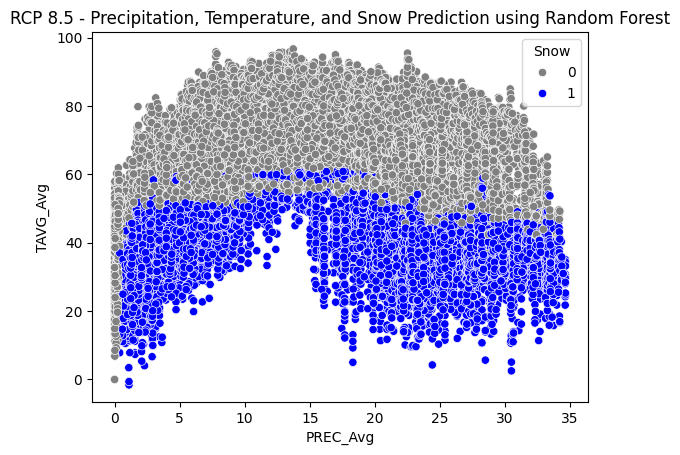

In [17]:
df_rcp85 = pd.read_csv('data/scenarios/rcp85_CanESM2-CanRCM4.csv', index_col=0, parse_dates=True)[['temp','prec_year']]
df_rcp85 = df_rcp85.rename(columns={'prec_year': 'PREC_Avg', 'temp': 'TAVG_Avg'})
df_rcp85 = df_rcp85[['PREC_Avg', 'TAVG_Avg']]

rcp85_snow_predictions = snow_rf.predict(df_rcp85)

sns.scatterplot(data=df_rcp85, x='PREC_Avg', y='TAVG_Avg', hue=rcp85_snow_predictions, palette=palette)
plt.legend(title='Snow')
plt.title('RCP 8.5 - Precipitation, Temperature, and Snow Prediction using Random Forest')
plt.show()

In [ ]:
# add to dataframe
df_rcp45['Snow'] = rcp45_snow_predictions
df_rcp85['Snow'] = rcp85_snow_predictions
print('RCP45 Snow Counts', df_rcp45['Snow'].value_counts())
print('RCP85 Snow Counts', df_rcp85['Snow'].value_counts())

df_rcp45 = df_rcp45.sort_index()
df_rcp85 = df_rcp85.sort_index()

RCP45 Snow Counts Snow
0    19821
1    14877
Name: count, dtype: int64
RCP85 Snow Counts Snow
0    20958
1    13740
Name: count, dtype: int64


'RCP 4.5:'

,PREC_Avg,TAVG_Avg,Snow
time,,,
2006-12-31,15.565096,50.225020,0.547945
2007-12-31,9.674080,53.932864,0.441096
2008-12-31,9.918364,53.482064,0.467213
2009-12-31,10.027209,53.777530,0.438356
2010-12-31,16.671421,51.442500,0.449315
...,...,...,...
2096-12-31,11.161823,56.978078,0.464481
2097-12-31,13.349434,56.972147,0.413699
2098-12-31,14.959070,56.744494,0.389041


'RCP 8.5:'

,PREC_Avg,TAVG_Avg,Snow
time,,,
2006-12-31,18.403358,49.859852,0.550685
2007-12-31,10.639320,53.083539,0.504110
2008-12-31,9.275744,55.680906,0.390710
2009-12-31,19.923854,51.323167,0.504110
2010-12-31,14.832339,50.920306,0.498630
...,...,...,...
2096-12-31,12.788787,64.236191,0.286885
2097-12-31,11.005758,64.454071,0.238356
2098-12-31,12.039667,61.355245,0.358904


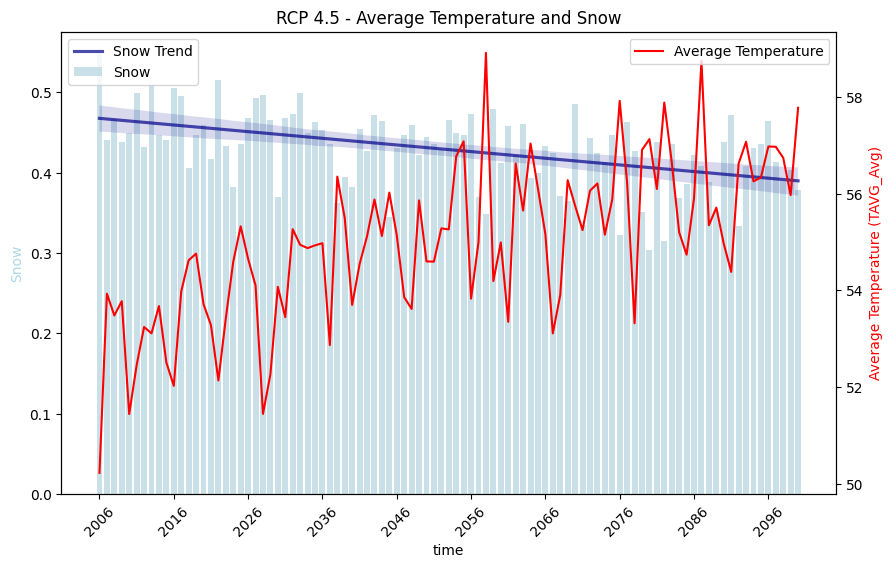

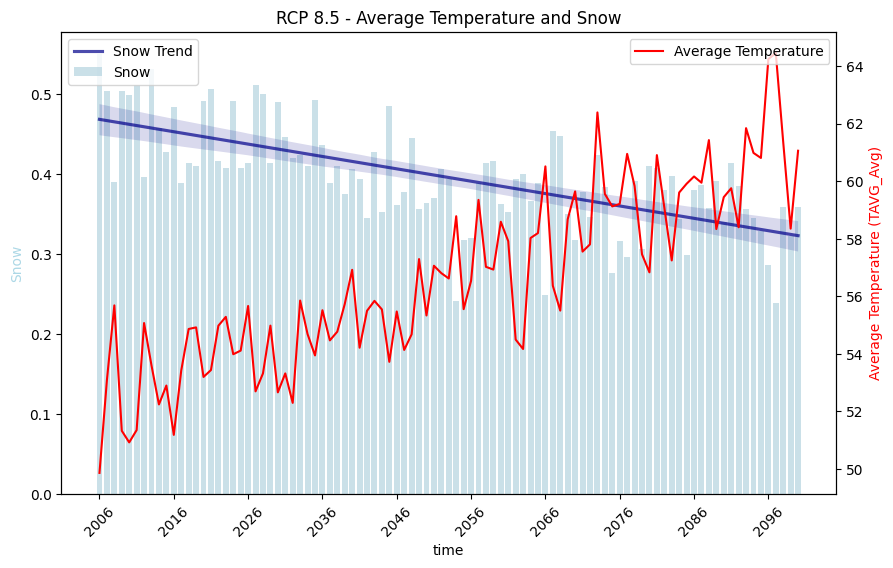

In [ ]:
df_annual_rcp45 = df_rcp45.resample('Y').mean()
df_annual_rcp85 = df_rcp85.resample('Y').mean()
display('RCP 4.5:', df_annual_rcp45)
display('RCP 8.5:', df_annual_rcp85)

fig, ax1 = plt.subplots(figsize=(10, 6))
sns.barplot(data=df_annual_rcp45, x=df_annual_rcp45.index.strftime('%Y'), y='Snow', 
            color='lightblue', ax=ax1, alpha=0.7, label='Snow')
sns.regplot(data=df_annual_rcp45, x=np.arange(len(df_annual_rcp45)), y='Snow', 
            scatter=False, color='darkblue', ax=ax1, line_kws={'alpha': 0.7}, label='Snow Trend')
ax2 = ax1.twinx()
sns.lineplot(data=df_annual_rcp45, x=df_annual_rcp45.index.strftime('%Y'), y='TAVG_Avg', 
             color='red', ax=ax2, label='Average Temperature')
years = df_annual_rcp45.index.year
tick_positions = np.arange(0, len(years), 10)
tick_labels = years[tick_positions]
ax1.set_xticks(tick_positions)
ax1.set_xticklabels(tick_labels, rotation=45)
ax1.set_title('RCP 4.5 - Average Temperature and Snow')
ax1.set_ylabel('Snow', color='lightblue')
ax2.set_ylabel('Average Temperature (TAVG_Avg)', color='red')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

fig, ax1 = plt.subplots(figsize=(10, 6))
sns.barplot(data=df_annual_rcp85, x=df_annual_rcp85.index.strftime('%Y'), y='Snow', 
            color='lightblue', ax=ax1, alpha=0.7, label='Snow')
sns.regplot(data=df_annual_rcp85, x=np.arange(len(df_annual_rcp85)), y='Snow', 
            scatter=False, color='darkblue', ax=ax1, line_kws={'alpha': 0.7}, label='Snow Trend')
ax2 = ax1.twinx()
sns.lineplot(data=df_annual_rcp85, x=df_annual_rcp85.index.strftime('%Y'), y='TAVG_Avg', 
             color='red', ax=ax2, label='Average Temperature')
years = df_annual_rcp85.index.year
tick_positions = np.arange(0, len(years), 10)
tick_labels = years[tick_positions]
ax1.set_xticks(tick_positions)
ax1.set_xticklabels(tick_labels, rotation=45)
ax1.set_title('RCP 8.5 - Average Temperature and Snow')
ax1.set_ylabel('Snow', color='lightblue')
ax2.set_ylabel('Average Temperature (TAVG_Avg)', color='red')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

In [ ]:
# Transform the data
scaler = MinMaxScaler()
df_rcp45_scaled = scaler.fit_transform(df_rcp45)
df_rcp85_scaled = scaler.fit_transform(df_rcp85)

# Reshape the data to 3D for LSTM (batch_size, timesteps, features)
n_steps = 10  # Use the same number of steps as used during training
df_rcp45_scaled = np.array([df_rcp45_scaled[i-n_steps:i] for i in range(n_steps, len(df_rcp45_scaled))])
df_rcp85_scaled = np.array([df_rcp85_scaled[i-n_steps:i] for i in range(n_steps, len(df_rcp85_scaled))])

rcp_45_soil_predictions = soil_lstm.predict(df_rcp45_scaled)
rcp_85_soil_predictions = soil_lstm.predict(df_rcp85_scaled)

# Add the predictions to the dataframe
df_rcp45['soilmoisture_Avg_8ft'] = np.concatenate([np.zeros(n_steps), rcp_45_soil_predictions.flatten()])
df_rcp85['soilmoisture_Avg_8ft'] = np.concatenate([np.zeros(n_steps), rcp_85_soil_predictions.flatten()])

# reverse transform scaler
df_rcp45['soilmoisture_Avg_8ft'] = scaler_target.inverse_transform(df_rcp45['soilmoisture_Avg_8ft'].values.reshape(-1, 1))
df_rcp85['soilmoisture_Avg_8ft'] = scaler_target.inverse_transform(df_rcp85['soilmoisture_Avg_8ft'].values.reshape(-1, 1))

display('RCP 4.5:', df_rcp45)
display('RCP 8.5:', df_rcp85)

1084/1084 [==============================] - 1s 957us/step


'RCP 4.5:'

,PREC_Avg,TAVG_Avg,Snow,soilmoisture_Avg_8ft
time,,,,
2006-01-01 12:00:00,0.004698,31.084023,0,9.200000
2006-01-02 12:00:00,0.306288,22.378100,1,9.200000
2006-01-03 12:00:00,0.358631,19.533260,1,9.200000
2006-01-04 12:00:00,0.358631,13.768091,1,9.200000
2006-01-05 12:00:00,0.360896,24.457006,1,9.200000
...,...,...,...,...
2100-12-27 12:00:00,27.937475,39.995155,1,25.947626
2100-12-28 12:00:00,27.938652,35.275560,1,25.833564
2100-12-29 12:00:00,27.938660,28.253563,1,25.831460


'RCP 8.5:'

,PREC_Avg,TAVG_Avg,Snow,soilmoisture_Avg_8ft
time,,,,
2006-01-01 12:00:00,0.004412,31.098322,0,9.200000
2006-01-02 12:00:00,0.307495,22.391829,1,9.200000
2006-01-03 12:00:00,0.359011,19.542048,1,9.200000
2006-01-04 12:00:00,0.359011,13.775345,1,9.200000
2006-01-05 12:00:00,0.361916,24.132610,1,9.200000
...,...,...,...,...
2100-12-27 12:00:00,32.626354,40.788258,1,25.361338
2100-12-28 12:00:00,32.643470,40.686527,1,25.366339
2100-12-29 12:00:00,32.649437,37.635570,1,25.386576


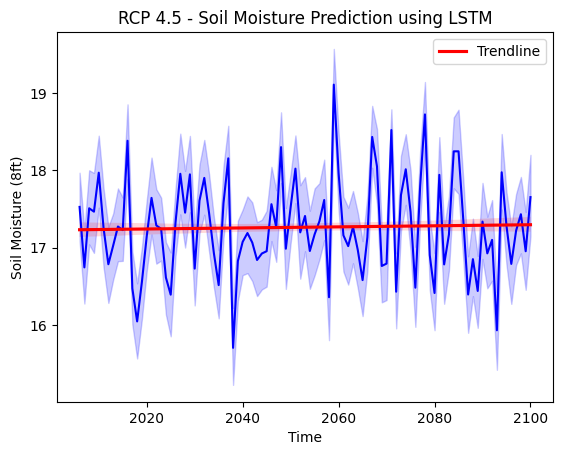

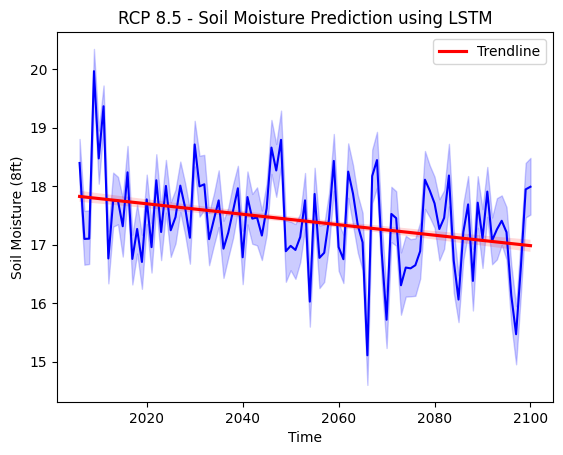

In [ ]:
# Plot for RCP 4.5
sns.lineplot(data=df_rcp45, x=df_rcp45.index.year, y='soilmoisture_Avg_8ft', color='blue')
sns.regplot(data=df_rcp45, x=df_rcp45.index.year, y='soilmoisture_Avg_8ft', scatter=False, color='red', label='Trendline')
plt.title('RCP 4.5 - Soil Moisture Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Soil Moisture (8ft)')
plt.legend()
plt.show()

# Plot for RCP 8.5
sns.lineplot(data=df_rcp85, x=df_rcp85.index.year, y='soilmoisture_Avg_8ft', color='blue')
sns.regplot(data=df_rcp85, x=df_rcp85.index.year, y='soilmoisture_Avg_8ft', scatter=False, color='red', label='Trendline')
plt.title('RCP 8.5 - Soil Moisture Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Soil Moisture (8ft)')
plt.legend()
plt.show()

In [ ]:
df_rcp45.to_csv('data/predictions/rcp45_snow_rf_soilmoisture_lstm_predictions.csv')
df_rcp85.to_csv('data/predictions/rcp85_snow_rf_soilmoisture_lstm_predictions.csv')